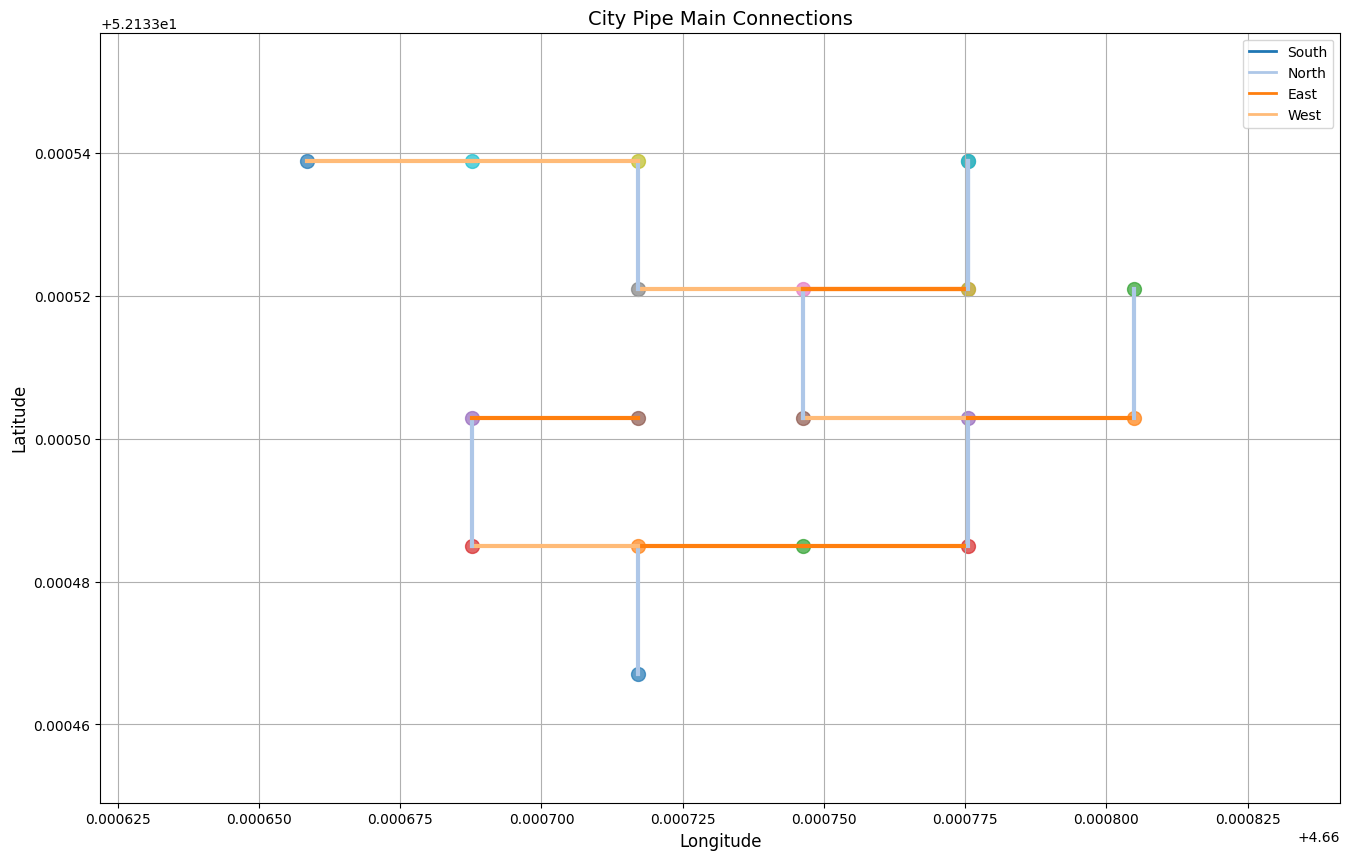

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Load the dataset
file_path = 'City_Pipe_Main.csv'  # Replace with your file path
city_pipe_main = pd.read_csv(file_path)

# Filter rows with valid coordinates
city_pipe_main_valid = city_pipe_main.dropna(subset=['Latitude', 'Longitude'])

# Generate unique color mappings for directions in the City Pipe Main dataset
directions = city_pipe_main_valid['Direction'].unique()
direction_colors = {direction: plt.cm.tab20(i) for i, direction in enumerate(directions)}

# Process edges and positions for City Pipe Main
city_edges = []
city_positions = {}

for _, row in city_pipe_main_valid.iterrows():
    city_positions[row['SegmentID']] = (row['Longitude'], row['Latitude'])
    if pd.notna(row['Parent Pipe']):
        parent_row = city_pipe_main_valid[city_pipe_main_valid['SegmentID'] == row['Parent Pipe']]
        if not parent_row.empty:
            parent_lat, parent_lon = parent_row.iloc[0]['Latitude'], parent_row.iloc[0]['Longitude']
            color = direction_colors.get(row['Direction'], 'black')
            city_edges.append(((parent_lon, parent_lat), (row['Longitude'], row['Latitude']), color))

# Calculate the center and zoom based on the dataset
center_lon = (city_pipe_main_valid['Longitude'].max() + city_pipe_main_valid['Longitude'].min()) / 2
center_lat = (city_pipe_main_valid['Latitude'].max() + city_pipe_main_valid['Latitude'].min()) / 2
lon_range = city_pipe_main_valid['Longitude'].max() - city_pipe_main_valid['Longitude'].min()
lat_range = city_pipe_main_valid['Latitude'].max() - city_pipe_main_valid['Latitude'].min()

# Adjust zoom factor
zoom_factor = 1.5

# Plot the visualization for City Pipe Main
plt.figure(figsize=(16, 10))

# Plot edges for City Pipe Main
for edge in city_edges:
    x_coords = [edge[0][0], edge[1][0]]
    y_coords = [edge[0][1], edge[1][1]]
    plt.plot(x_coords, y_coords, color=edge[2], linewidth=3, label='City Pipe Main Edge')

# Plot nodes for City Pipe Main
for node, (lon, lat) in city_positions.items():
    plt.scatter(lon, lat, s=100, alpha=0.7, label='City Pipe Main Node')

# Add title, labels, and legend
plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)
plt.title("City Pipe Main Connections", fontsize=14)

# Custom legend for directions
custom_lines = [Line2D([0], [0], color=color, lw=2) for color in direction_colors.values()]
plt.legend(custom_lines, list(direction_colors.keys()), loc='upper right', fontsize=10)

# Adjust axes to zoom and center on the data
plt.xlim(center_lon - (lon_range / 2 * zoom_factor), center_lon + (lon_range / 2 * zoom_factor))
plt.ylim(center_lat - (lat_range / 2 * zoom_factor), center_lat + (lat_range / 2 * zoom_factor))

plt.grid(True)
plt.show()
